In [41]:
import os
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm

    
import os
import random
import pickle
import numpy as np
import copy
from tqdm import tqdm
from scipy.ndimage import rotate

# Helper functions
def rotate_image(image, angle):
    return np.array([rotate(img, angle, reshape=False, mode='nearest') for img in image])

def rotate_trajectory(trajectory, angle_degrees):
    angle_rad = np.deg2rad(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    traj_xy = trajectory[:, :2]
    rotated_xy = traj_xy @ rotation_matrix.T
    trajectory[:, :2] = rotated_xy
    return trajectory

def augment_and_save(file_list, save_dir,
                     use_depth_noise=True, depth_noise_factor=0.1,
                     use_trajectory_noise=True, trajectory_noise_std=0.05,
                     use_random_rotation=True, max_rotation_degrees=5):

    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    for file_path in tqdm(file_list):
        with open(file_path, 'rb') as f:
            original = pickle.load(f)

        # === 1. Save horizontally flipped version ===
        data_flip = copy.deepcopy(original)
        data_flip['camera'] = data_flip['camera'][:, ::-1, :]
        data_flip['depth'] = data_flip['depth'][:, ::-1, :]
        data_flip['sdc_history_feature'][:, 1] *= -1
        if 'sdc_future_feature' in data_flip:
            data_flip['sdc_future_feature'][:, 1] *= -1

        base = os.path.basename(file_path)
        flip_path = os.path.join(save_dir, f"augmented_flip_{base}")
        with open(flip_path, 'wb') as f:
            pickle.dump(data_flip, f)
        new_files.append(flip_path)

        # === 2. Add noise/rotation to flipped version and save again ===
        data_aug = copy.deepcopy(data_flip)

        if use_random_rotation and random.random() < 0.2:
            angle = random.uniform(-max_rotation_degrees, max_rotation_degrees)
            data_aug['camera'] = rotate_image(data_aug['camera'], angle)
            data_aug['depth'] = rotate_image(data_aug['depth'], angle)
            if 'sdc_history_feature' in data_aug:
                data_aug['sdc_history_feature'] = rotate_trajectory(data_aug['sdc_history_feature'], angle)
            if 'sdc_future_feature' in data_aug:
                data_aug['sdc_future_feature'] = rotate_trajectory(data_aug['sdc_future_feature'], angle)
                
        if use_trajectory_noise and random.random() < 0.3:
            history_shape = data_aug['sdc_history_feature'].shape
            noise_history = np.random.normal(0, trajectory_noise_std, history_shape)
            data_aug['sdc_history_feature'] += noise_history
        
            if 'sdc_future_feature' in data_aug:
                future_shape = data_aug['sdc_future_feature'].shape
                noise_future = np.random.normal(0, trajectory_noise_std, future_shape)
                data_aug['sdc_future_feature'] += noise_future

        if use_depth_noise and random.random() < 0.2:
            noise = depth_noise_factor * data_aug['depth'] * np.random.normal(0, 1, data_aug['depth'].shape)
            data_aug['depth'] = np.clip(data_aug['depth'] + noise, 0, None)

        noisy_path = os.path.join(save_dir, f"augmented_noisy_{base}")
        with open(noisy_path, 'wb') as f:
            pickle.dump(data_aug, f)
        new_files.append(noisy_path)

    return new_files


if not os.path.exists('augmented_train_m2'):
    train_data_dir = 'train'
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]

    augmented_train = augment_and_save(
        train_files,
        save_dir='augmented_train_m2',
        use_depth_noise=True,
        use_trajectory_noise=True,
        use_random_rotation=False,
    )
    print("Augmented data saved to 'augmented_train_m2' directory.")
else:
    print("Augmented data already exists.")


100%|██████████| 5000/5000 [00:13<00:00, 372.58it/s]

Augmented data saved to 'augmented_train' directory.


In [44]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])
        semantic = torch.FloatTensor(data['semantic_label'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic,
                'future': future
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic,

            }

In [53]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything


class SharedEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Output: B x 512 x H/32 x W/32
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        self.visual_fc = nn.Linear(512, 256)  # ResNet18 last conv outputs 512 channels

    def forward(self, x):
        # Encode image
        batch_size = x.size(0)
        visual_features = self.visual_encoder(x)  # (B, 512, H', W')
        
        # Store the spatial features for depth prediction
        spatial_features = visual_features  # Keep the spatial information for depth decoder
        
        # Pool and project features for trajectory prediction
        pooled_features = self.visual_pool(visual_features).view(batch_size, -1)  # (B, 512)
        projected_features = self.visual_fc(pooled_features)  # (B, 256)
        
        return projected_features, spatial_features


class DepthDecoder(nn.Module):
    def __init__(self, in_channels=512, output_size=(200, 300)):
        super().__init__()
        self.output_size = output_size
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )
    def forward(self, x):
        # Initial upsampling through the network
        x = self.upsample(x)  
        # Final resize to match ground truth dimensions
        return F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)


class HistoryEncoder(nn.Module):
    def __init__(self, seq_len=21, feat_dim=2, hidden_dim=128): # changed the dimenstion to 2 instead of 3
        super().__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        
        self.fc = nn.Sequential(
            nn.Linear(seq_len * feat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
            nn.ReLU()
        )

    def forward(self, history):
        # history: B x T x 2
        batch_size = history.size(0)
        # Flatten the temporal dimension
        history_flat = history.reshape(batch_size, -1)  # B x (T*2)
        return self.fc(history_flat)  # B x hidden_dim


class MultiModalMultiTaskModel(nn.Module):
    def __init__(self, num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300)):
        super().__init__()
        self.num_modes = num_modes
        self.pred_len = pred_len
        
        # Visual encoder
        self.image_encoder = SharedEncoder()
        self.depth_decoder = DepthDecoder(in_channels=512, output_size=depth_output_size)
        
        # History encoder
        self.hist_encoder = HistoryEncoder(seq_len=hist_seq_len, feat_dim=hist_feat_dim, hidden_dim=128)
        
        # Fusion layer with batch normalization
        self.fusion = nn.Sequential(
            nn.Linear(256 + 128, 512),  # Changed from 512+128 to 256+128
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Trajectory decoder - predict multiple modes
        self.traj_decoder = nn.Linear(512, num_modes * pred_len * 2)  # Predict x,y coordinates for each mode
        
        # Confidence scores for each mode
        self.confidence_decoder = nn.Linear(512, num_modes)

    def forward(self, img, hist):
        # Encode image - now returns both projected features and spatial features
        img_feat, spatial_feat = self.image_encoder(img)
        
        # Use spatial features for depth prediction
        depth_pred = self.depth_decoder(spatial_feat)
        
        # Encode history
        hist_feat = self.hist_encoder(hist)
        
        # Combine features
        combined = torch.cat([img_feat, hist_feat], dim=1)
        
        # Fusion layer
        fused = self.fusion(combined)
        
        # Decode trajectories and confidence scores
        traj_pred = self.traj_decoder(fused)
        traj_pred = traj_pred.view(-1, self.num_modes, self.pred_len, 2)  # B x M x T x 2
        
        # Predict confidence scores
        conf_pred = self.confidence_decoder(fused)
        conf_pred = F.softmax(conf_pred, dim=1)  # Normalize to probabilities
        
        # Select best trajectory based on confidence
        best_mode = torch.argmax(conf_pred, dim=1)  # B
        best_traj = torch.gather(traj_pred, 1, 
                              best_mode.view(-1, 1, 1, 1).expand(-1, 1, self.pred_len, 2))
        best_traj = best_traj.squeeze(1)  # B x T x 2
        
        return depth_pred, traj_pred, conf_pred, best_traj


def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading = False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error
    
    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)
        
    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only x, y coordinates from ground truth if needed
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]
    
    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]
    
    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B] - Use highest confidence
    else:
        # Fall back to minimum ADE if no confidences provided
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]
    
    # Get errors for best mode per batch element
    batch_indices = torch.arange(pred_trajectories.size(0), device=pred_trajectories.device)
    best_mode_error = error_per_mode[batch_indices, best_mode_idx]  # [B, T]
    
    # Compute metrics
    ade = best_mode_error.mean().item()
    fde = best_mode_error[:, -1].mean().item()
    
    return ade, fde


# Lightning
from pytorch_lightning import LightningModule

class LightningDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, scheduler_patience=5, 
                 max_pred_len=60, num_modes=4, curriculum_epochs=20, grad_clip=7.0,
                 ):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.max_pred_len = max_pred_len
        self.curriculum_epochs = curriculum_epochs
        self.grad_clip = grad_clip
        self.model = MultiModalMultiTaskModel(num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300))
        
        self.scheduler_patience = scheduler_patience
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Patience: {self.scheduler_patience}\n")
    
    def forward(self, camera, history):
        history= history[:, :, :2] # [B, T, 2]
        return self.model(camera, history)
    
    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        depth_gt = batch['depth'].permute(0, 3, 1, 2)          # [B, 200, 300, 1]
        
        # Get current epoch
        current_epoch = self.current_epoch
        
        # Curriculum learning: gradually increase prediction horizon
        if current_epoch < self.curriculum_epochs:
            pred_len = int((current_epoch / self.curriculum_epochs) * self.max_pred_len) + 1
        else:
            pred_len = self.max_pred_len
            

        depth_pred, traj_pred, conf_pred, best_traj = self(camera, history)
        # Truncate predictions and ground truth
        best_traj = best_traj[:, :pred_len]
        future = future[:, :pred_len]

        # Compute losses
        depth_loss = nn.SmoothL1Loss()(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss()(best_traj, future[:, :, :2])
        
        # Combine losses with weighted sum
        loss = 0.1 * depth_loss + traj_loss
                
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_depth_loss', depth_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_traj_loss', traj_loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss

        

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        depth_gt = batch['depth']

        # Forward pass
        depth_pred, traj_pred, conf_pred, best_traj = self(camera, history)
        depth_gt = depth_gt.permute(0, 3, 1, 2)

        # Compute losses
        depth_loss = nn.SmoothL1Loss()(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss()(best_traj, future[:, :, :2])
        loss = 0.1 * depth_loss + traj_loss
        
        # Compute ADE and FDE
        ade, fde = compute_ade_fde(traj_pred, future)

        # Log validation metrics
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_depth_loss', depth_loss, prog_bar=True, sync_dist=True)
        self.log('val_traj_loss', traj_loss, prog_bar=True, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)

        return {'val_loss': loss, 'val_depth_loss': depth_loss, 'val_traj_loss': traj_loss, 'val_ade': ade, 'val_fde': fde}

    def test_step(self, batch, batch_idx):
        # dont't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        # Use AdamW optimizer with better weight decay handling
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler with cosine annealing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.epochs,
            eta_min=1e-6
        )
        
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            },
        }

import random        
# Training function
def run_experiment( max_epochs=50, batch_size=32, lr=1e-4, weight_decay=2e-6, scheduler_patience=5, 
                   augment_train=True, augment_val=False, seed=42, logger_name='multitask_driving_planner_with_encoder_aug'):
    # Set random seed for reproducibility
    pl.seed_everything(seed)

    # Define paths to data
    train_data_dir = "train"
    val_data_dir = "val"
    augmented_train_data_dir = "augmented_train_m2"

    # Get file lists
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

    augmented_train_files = [os.path.join(augmented_train_data_dir, f) for f in os.listdir(augmented_train_data_dir) if f.endswith('.pkl')]
    
    if augment_train:
        all_train_files = train_files + augmented_train_files
        random.Random(42).shuffle(all_train_files)
        train_dataset = DrivingDataset(all_train_files)
        print("length of train dataset ", len(all_train_files))
        
    else:
        train_dataset = DrivingDataset(train_files)

    if augment_val:
        val_dataset = DrivingDataset(val_files)
    else:
        val_dataset = DrivingDataset(val_files)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Initialize model with Lightning wrapper
    model = LightningDrivingPlanner(
        lr=lr, 
        weight_decay=weight_decay, 
        epochs=max_epochs, 
        scheduler_patience=scheduler_patience,
    )

    # Initialize logger
    logger = TensorBoardLogger(save_dir='lightning_logs', name=logger_name)
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # Setup checkpoint callback
    # get logger version
    version = logger.version
    # get the current time for unique checkpoint names
    filename = f"driving_planner_version_{version}"
    print(f"Model version: {version}\n====================================\n ")
    # create a directory for the checkpoints
    checkpoint_dir = 'checkpoints'+f"/{logger_name}/"
    # Checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename= filename + '_{epoch:02d}_{val_ade:.4f}',
        monitor='val_ade',
        mode='min',
        save_top_k=2,
        save_last=True,
        verbose=True
    )

    # Create trainer with limited epochs for quick overfitting test
    trainer = pl.Trainer(
        max_epochs=max_epochs, 
        logger=logger,
        accelerator='auto',  # Automatically select GPU if available
        devices='auto',
        precision=16,  # Use mixed precision
        log_every_n_steps=5,  # Logging freq
        gradient_clip_val=5.0,
        enable_checkpointing=True,  
        callbacks=[checkpoint_callback, lr_monitor],
    )

    # Train on the small dataset
    trainer.fit(model, train_loader, val_loader)
    # return best model and validation loader for testing
    best_model_path = checkpoint_callback.best_model_path
    best_model_val_loss = checkpoint_callback.best_model_score
    print(f"Best model val_loss: {best_model_val_loss}\nBest model path: {best_model_path}")
    # Load the best model
    model = LightningDrivingPlanner.load_from_checkpoint(best_model_path)

    # Test the model on the validation set again to be sure
    model.eval()
    trainer.validate(model, val_loader)
    return model, val_loader, best_model_val_loss

In [54]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=130)

Seed set to 42


length of train dataset  15000


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-87ebb86f-d283-5a16-ba60-0eb36616339c]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 13.7 M | train
-----------------------------------------------------------
13.7 M    Trainable params
0         Non-trainable params
13.7 M    Total params
54.941    Total estimated model params size (MB)
98        Modules in train mode
0         Modules in eval mode



Model initialized with parameters:
Learning Rate: 0.0001
Weight Decay: 2e-06
Number of Epochs: 130
Number of Modes: 4
Scheduler Patience: 5

Model version: 4
 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 469: 'val_ade' reached 14.80386 (best 14.80386), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=00_val_ade=14.8039.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1407: 'val_ade' reached 14.63484 (best 14.63484), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=02_val_ade=14.6348.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1876: 'val_ade' reached 14.46336 (best 14.46336), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=03_val_ade=14.4634.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 2345: 'val_ade' reached 14.19321 (best 14.19321), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=04_val_ade=14.1932.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 2814: 'val_ade' reached 13.82518 (best 13.82518), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=05_val_ade=13.8252.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 3283: 'val_ade' reached 13.46508 (best 13.46508), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=06_val_ade=13.4651.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 3752: 'val_ade' reached 13.16440 (best 13.16440), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=07_val_ade=13.1644.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 4221: 'val_ade' reached 12.47333 (best 12.47333), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=08_val_ade=12.4733.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 4690: 'val_ade' reached 11.87961 (best 11.87961), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=09_val_ade=11.8796.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 5159: 'val_ade' reached 11.42501 (best 11.42501), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=10_val_ade=11.4250.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 5628: 'val_ade' reached 10.76981 (best 10.76981), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=11_val_ade=10.7698.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 6097: 'val_ade' reached 10.19991 (best 10.19991), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=12_val_ade=10.1999.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 6566: 'val_ade' reached 9.55028 (best 9.55028), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=13_val_ade=9.5503.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 7035: 'val_ade' reached 8.10389 (best 8.10389), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=14_val_ade=8.1039.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 7504: 'val_ade' reached 7.07249 (best 7.07249), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=15_val_ade=7.0725.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 7973: 'val_ade' reached 6.02415 (best 6.02415), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=16_val_ade=6.0242.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 8442: 'val_ade' reached 5.25867 (best 5.25867), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=17_val_ade=5.2587.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 8911: 'val_ade' reached 3.91586 (best 3.91586), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=18_val_ade=3.9159.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 9380: 'val_ade' reached 3.15065 (best 3.15065), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=19_val_ade=3.1506.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 9849: 'val_ade' reached 2.41877 (best 2.41877), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=20_val_ade=2.4188.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 10318: 'val_ade' reached 1.78529 (best 1.78529), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=21_val_ade=1.7853.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 10787: 'val_ade' reached 1.56680 (best 1.56680), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=22_val_ade=1.5668.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 11256: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 11725: 'val_ade' reached 1.55977 (best 1.55977), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=24_val_ade=1.5598.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 12194: 'val_ade' reached 1.47585 (best 1.47585), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=25_val_ade=1.4759.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 12663: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 13132: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 13601: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 14070: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 14539: 'val_ade' reached 1.52682 (best 1.47585), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=30_val_ade=1.5268.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 15008: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 15477: 'val_ade' reached 1.45221 (best 1.45221), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=32_val_ade=1.4522.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 15946: 'val_ade' reached 1.40961 (best 1.40961), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=33_val_ade=1.4096.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 16415: 'val_ade' reached 1.42369 (best 1.40961), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=34_val_ade=1.4237.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 16884: 'val_ade' reached 1.39432 (best 1.39432), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=35_val_ade=1.3943.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 17353: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 17822: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 18291: 'val_ade' reached 1.38716 (best 1.38716), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=38_val_ade=1.3872.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 18760: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 19229: 'val_ade' reached 1.39400 (best 1.38716), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=40_val_ade=1.3940.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 19698: 'val_ade' reached 1.37046 (best 1.37046), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=41_val_ade=1.3705.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 20167: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 20636: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 21105: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 21574: 'val_ade' reached 1.33976 (best 1.33976), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=45_val_ade=1.3398.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 22043: 'val_ade' reached 1.30533 (best 1.30533), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=46_val_ade=1.3053.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 22512: 'val_ade' reached 1.31003 (best 1.30533), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=47_val_ade=1.3100.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 22981: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 23450: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 23919: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 24388: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 24857: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 25326: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 25795: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 26264: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 26733: 'val_ade' reached 1.30280 (best 1.30280), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=56_val_ade=1.3028.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 27202: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 27671: 'val_ade' reached 1.29948 (best 1.29948), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=58_val_ade=1.2995.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 28140: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 28609: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 29078: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 29547: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 30016: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 30485: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 30954: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 31423: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 31892: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 32361: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 32830: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 33299: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 33768: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 34237: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 34706: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 35175: 'val_ade' reached 1.27694 (best 1.27694), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=74_val_ade=1.2769.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 35644: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 36113: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 36582: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 37051: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 37520: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 37989: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 38458: 'val_ade' reached 1.28898 (best 1.27694), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=81_val_ade=1.2890.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 38927: 'val_ade' reached 1.26311 (best 1.26311), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=82_val_ade=1.2631.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 39396: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 39865: 'val_ade' reached 1.27211 (best 1.26311), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=84_val_ade=1.2721.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 40334: 'val_ade' reached 1.26923 (best 1.26311), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=85_val_ade=1.2692.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 40803: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 41272: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 41741: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 42210: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 42679: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 43148: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 43617: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 44086: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 44555: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 45024: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 45493: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 45962: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 46431: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 46900: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100, global step 47369: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101, global step 47838: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102, global step 48307: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103, global step 48776: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104, global step 49245: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105, global step 49714: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106, global step 50183: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107, global step 50652: 'val_ade' reached 1.26752 (best 1.26311), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=107_val_ade=1.2675.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108, global step 51121: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109, global step 51590: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110, global step 52059: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111, global step 52528: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112, global step 52997: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113, global step 53466: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114, global step 53935: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115, global step 54404: 'val_ade' reached 1.26118 (best 1.26118), saving model to '/home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=115_val_ade=1.2612.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116, global step 54873: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117, global step 55342: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118, global step 55811: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119, global step 56280: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 120, global step 56749: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 121, global step 57218: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 122, global step 57687: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 123, global step 58156: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 124, global step 58625: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 125, global step 59094: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 126, global step 59563: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 127, global step 60032: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 128, global step 60501: 'val_ade' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 129, global step 60970: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=130` reached.


Best model val_loss: 1.261179804801941
Best model path: /home/my_notebooks/milestone2/checkpoints/multitask_driving_planner_with_encoder_aug/driving_planner_version_4_epoch=115_val_ade=1.2612.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-87ebb86f-d283-5a16-ba60-0eb36616339c]



Model initialized with parameters:
Learning Rate: 0.0001
Weight Decay: 2e-06
Number of Epochs: 130
Number of Modes: 4
Scheduler Patience: 5



Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │     1.261179804801941     │
│      val_depth_loss       │     0.381931334733963     │
│          val_fde          │    3.4181087017059326     │
│         val_loss          │    0.7752931714057922     │
│       val_traj_loss       │     0.737099826335907     │
└───────────────────────────┴───────────────────────────┘

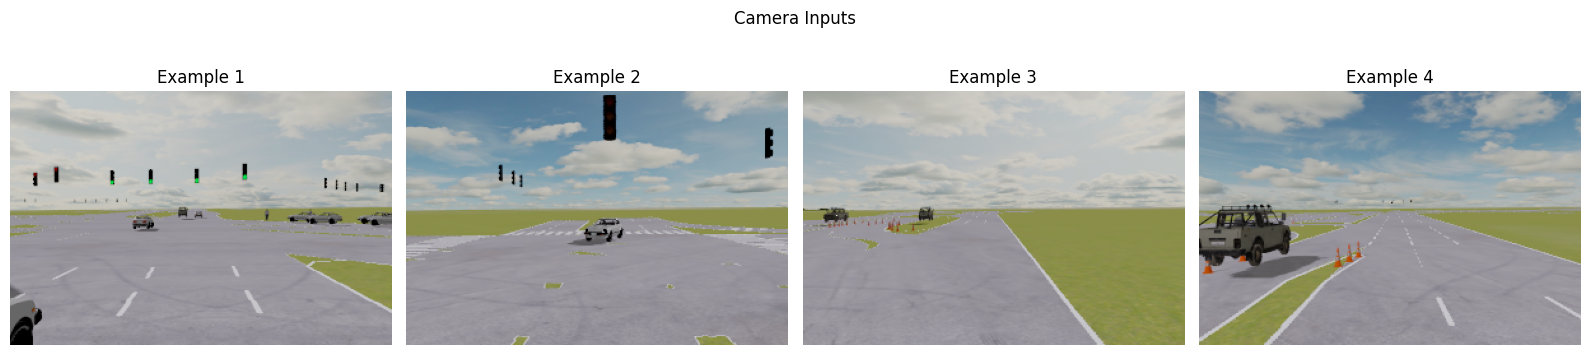

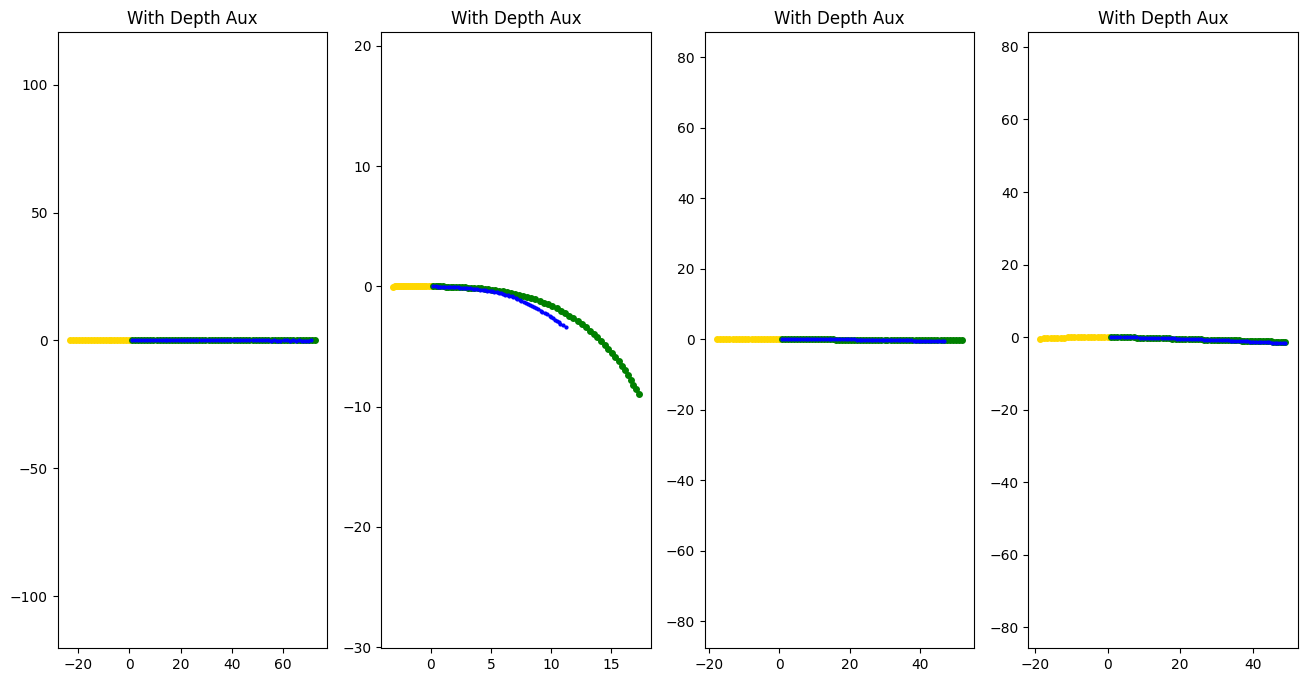

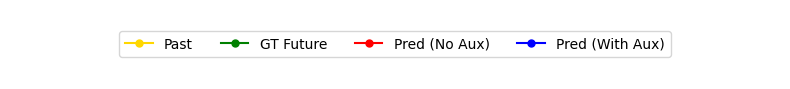

<Figure size 640x480 with 0 Axes>

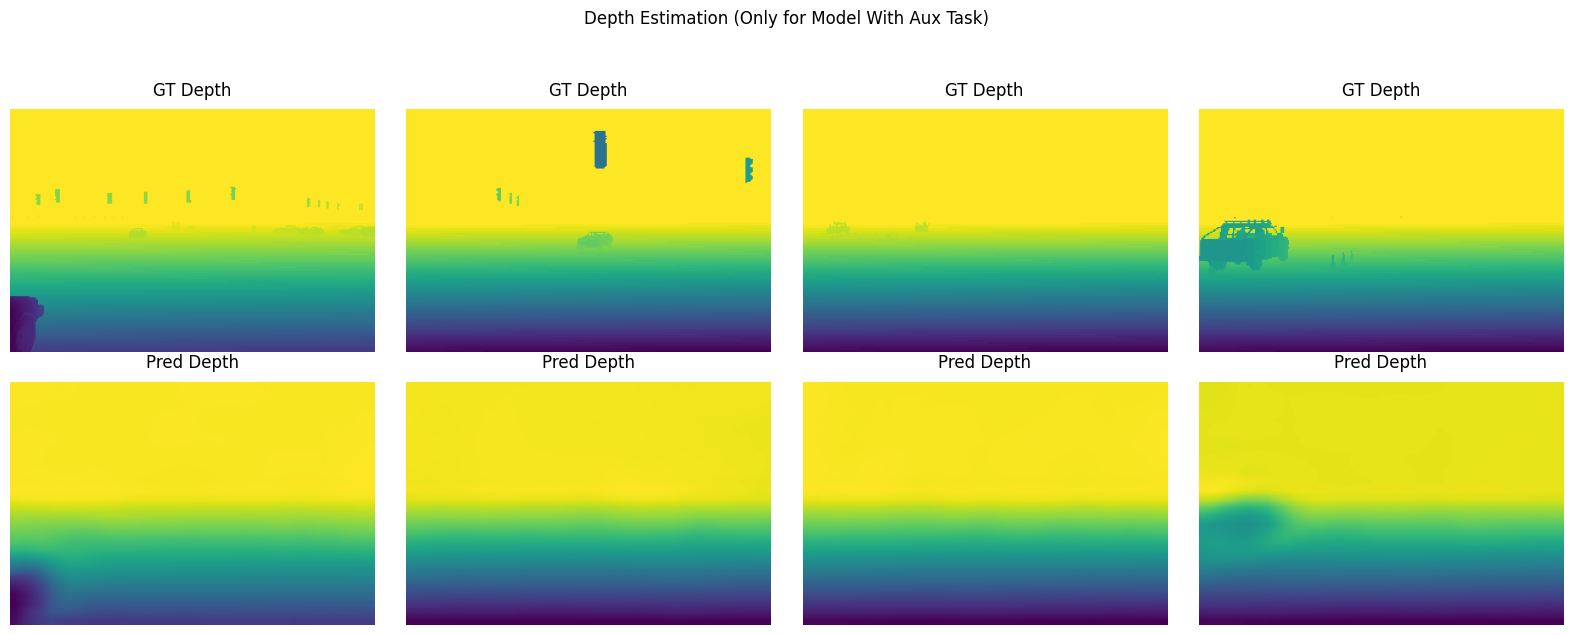

In [64]:
import matplotlib.pyplot as plt
import random

def visualize_comparison(val_loader, model, device):
    
    model.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    with torch.no_grad():
        #pred_no_aux, _ = model_no_aux(camera, history)
        #pred_with_aux, pred_depth = model_with_aux(camera, history)
        depth_pred, traj_pred, conf_pred, best_traj = model(camera, history)
        # Truncate predictions and ground truth
        pred_depth = depth_pred.permute(0, 2, 3, 1)
        pred_with_aux= best_traj

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # With aux
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], '.-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("With Depth Aux")
        ax[i].axis("equal")
 
    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    return future, pred_with_aux, depth, pred_depth


# Call at the end after training 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= model.to(device)
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device)

In [62]:
trainer = pl.Trainer()

trainer.validate(model, val_loader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-87ebb86f-d283-5a16-ba60-0eb36616339c]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │     1.261459231376648     │
│      val_depth_loss       │     0.37747722864151      │
│          val_fde          │    3.4178807735443115     │
│         val_loss          │    0.7750028967857361     │
│       val_traj_loss       │     0.737254798412323     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7750028967857361,
  'val_depth_loss': 0.37747722864151,
  'val_traj_loss': 0.737254798412323,
  'val_ade': 1.261459231376648,
  'val_fde': 3.4178807735443115}]

In [60]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature
device = "cuda"
import pandas as pd
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        #pred_future, _ = model(camera, history)
        depth_pred, traj_pred, conf_pred, pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2_16.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])
Shape of df_xy: (1000, 121)


In [ ]:
class LightningDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, scheduler_patience=5, 
                 max_pred_len=60, num_modes=6, curriculum_epochs=20, grad_clip=7.0,
                 depth_weight=0.1):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.max_pred_len = max_pred_len
        self.curriculum_epochs = curriculum_epochs
        self.grad_clip = grad_clip
        self.depth_weight = depth_weight
        
        self.model = MultiModalMultiTaskModel(
            num_modes=num_modes, 
            pred_len=max_pred_len, 
            hist_seq_len=21, 
            hist_feat_dim=2, 
            depth_output_size=(200, 300)
        )
        
        self.scheduler_patience = scheduler_patience
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Depth Weight: {self.depth_weight}")
        print(f"Scheduler Patience: {self.scheduler_patience}\n")
    
    def forward(self, camera, history):
        # Ensure we're only using x,y coordinates (first 2 channels)
        history = history[:, :, :2]  # [B, T, 2]
        return self.model(camera, history)
    
    def configure_optimizers(self):
        # Use AdamW optimizer
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.lr, 
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler with patience
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min',
            factor=0.5, 
            patience=self.scheduler_patience, 
            verbose=True
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_ade",  # Monitor ADE for scheduling
                "frequency": 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        depth_gt = batch['depth'].permute(0, 3, 1, 2)  # [B, 1, 200, 300]
        
        # Apply curriculum learning: gradually increase prediction horizon
        current_epoch = self.current_epoch
        if current_epoch < self.curriculum_epochs:
            pred_len = int((current_epoch / self.curriculum_epochs) * self.max_pred_len) + 1
        else:
            pred_len = self.max_pred_len
            
        # Forward pass
        depth_pred, traj_pred, conf_pred, best_traj = self(camera, history)
        
        # Truncate predictions and ground truth based on curriculum
        best_traj = best_traj[:, :pred_len]
        future_xy = future[:, :pred_len, :2]  # Just x,y coordinates
        
        # Compute trajectory loss with both best mode and all modes
        best_traj_loss = F.smooth_l1_loss(best_traj, future_xy)
        
        # Compute depth loss
        depth_loss = F.smooth_l1_loss(depth_pred, depth_gt)
        
        # Weighted multi-task loss (prioritizing trajectory)
        loss = best_traj_loss + self.depth_weight * depth_loss
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_depth_loss', depth_loss, on_step=True, on_epoch=True)
        self.log('train_traj_loss', best_traj_loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        depth_gt = batch['depth'].permute(0, 3, 1, 2)  # [B, 1, 200, 300]
        
        # Forward pass
        depth_pred, traj_pred, conf_pred, best_traj = self(camera, history)
        
        # Compute losses
        depth_loss = F.smooth_l1_loss(depth_pred, depth_gt)
        best_traj_loss = F.smooth_l1_loss(best_traj, future[:, :, :2])
        
        # Weighted multi-task loss
        loss = best_traj_loss + self.depth_weight * depth_loss
        
        # Compute ADE and FDE
        ade, fde = compute_ade_fde(traj_pred, future, confidences=conf_pred)
        
        # Log validation metrics
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_depth_loss', depth_loss, sync_dist=True)
        self.log('val_traj_loss', best_traj_loss, prog_bar=True, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)
        
        return {'val_loss': loss, 'val_ade': ade, 'val_fde': fde}


def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading=False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error
    
    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)
        include_heading: Whether to include heading in distance calculation
        confidences: Tensor of shape [B, M] with confidence scores for each mode
    
    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only relevant coordinates from ground truth
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]
    
    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]
    
    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B]
    else:
        # Otherwise use minimum ADE for mode selection
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]
    
    # Get errors for best mode perimport torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pytorch_lightning as pl


class SharedEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Use ResNet18 with pretrained weights for feature extraction
        resnet = models.resnet18(weights='DEFAULT' if pretrained else None)
        
        # Extract the convolutional blocks (remove avgpool and fc layers)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Output: B x 512 x H/32 x W/32
        
        # Spatial attention mechanism for feature refinement
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Channel attention (SE-like module)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 512, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Feature refinement for trajectory prediction
        self.traj_features = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),    # Global pooling
            nn.Flatten(),               # Flatten to vector
            nn.Linear(512, 512),        # Project to same dimension
            nn.BatchNorm1d(512),        # Normalize features
            nn.ReLU(inplace=True),      # Activation
            nn.Dropout(0.3)             # Prevent overfitting
        )

    def forward(self, x):
        # Get visual features from ResNet
        features = self.encoder(x)  # B x 512 x H/32 x W/32
        
        # Apply spatial attention
        spatial_attn = self.spatial_attention(features)
        spatially_refined = features * spatial_attn
        
        # Apply channel attention
        channel_attn = self.channel_attention(features)
        refined_features = spatially_refined * channel_attn
        
        # Prepare features for trajectory prediction
        traj_features = self.traj_features(refined_features)  # B x 512
        
        # Return both full feature maps (for depth) and vector features (for trajectory)
        return refined_features, traj_features


class DepthDecoder(nn.Module):
    def __init__(self, in_channels=512, output_size=(200, 300)):
        super().__init__()
        self.output_size = output_size
        
        # Simple decoder with upsampling blocks
        self.decoder = nn.Sequential(
            # First upsampling block
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            # Second upsampling block
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            # Third upsampling block
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            
            # Final convolution
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, features):
        # Process features through decoder
        x = self.decoder(features)
        
        # Final resize to match ground truth dimensions
        return F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)


class HistoryEncoder(nn.Module):
    def __init__(self, seq_len=21, feat_dim=2, hidden_dim=128):
        super().__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        
        # Temporal CNN for initial feature extraction
        self.temporal_cnn = nn.Sequential(
            nn.Conv1d(feat_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # LSTM for learning temporal dependencies
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Final projection
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # *2 for bidirectional
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

    def forward(self, history):
        # history: B x T x 2
        batch_size = history.size(0)
        
        # Apply temporal CNN (requires [B, C, T] format)
        history_trans = history.transpose(1, 2)  # B x 2 x T
        cnn_out = self.temporal_cnn(history_trans)  # B x 128 x T
        cnn_out = cnn_out.transpose(1, 2)  # B x T x 128
        
        # Process through LSTM
        lstm_out, (hidden, _) = self.lstm(cnn_out)  # lstm_out: B x T x (hidden_dim*2)
        
        # Use last hidden state from both directions
        hidden = torch.cat([hidden[0], hidden[1]], dim=1)  # B x (hidden_dim*2)
        
        # Final projection
        return self.fc(hidden)  # B x hidden_dim